The following colab notebook is based off the following tutorial on Keras: https://keras.io/examples/vision/yolov8/

This notebook is the first in our pipeline, as it is responsible for training the Keras network as well as getting the centroids on the evaluation images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You will be asked to provide your Kaggle username and API key.

In [ ]:
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/duythanhng/parking-lot-database-for-yolo")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: egolab
Your Kaggle Key: ··········


100%|██████████| 1.91G/1.91G [00:34<00:00, 58.8MB/s]


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import gc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.5 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
# hyperparameters:

SPLIT_RATIO_VAL = 0.2
SPLIT_RATIO_TEST = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
MAX_NUM_BOXES = 100

In [ ]:

class_ids = [ "Unocc" , "Occ"]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "/content/parking-lot-database-for-yolo/PKLotYoloData/HasXML/PUCPR/"
path_annot = "/content/parking-lot-database-for-yolo/PKLotYoloData/HasXML/PUCPR/"

# Get all TXT file paths in path_annot and sort them
# https://stackoverflow.com/questions/5817209/browse-files-and-subfolders-in-python
xml_files = sorted(
[os.path.join(root, name)
             for root, dirs, files in os.walk(path_annot)
             for name in files
             if name.endswith((".txt"))]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
[os.path.join(root, name)
             for root, dirs, files in os.walk(path_images)
             for name in files
             if name.endswith((".jpg"))]
)

# Remove files with missing class labels:

text_files = []
for file in jpg_files:
  try:
    image_jpg = pd.read_csv(file.replace(".jpg",".txt"))
    if image_jpg is not None:
      text_files.append(file.replace(".jpg", '.txt'))
  except:
    continue
xml_files = text_files



In [ ]:
def parse_annotation_text(text_file):
    # Rewrite using pandas

    image_bbs = pd.read_csv(text_file, delimiter = " ")

    #image_name = root.find("filename").text
    image_path = text_file.replace("labels", "images")
    image_path = image_path.replace(".txt", ".jpg")

    img_jpg = cv2.imread(image_path)

    boxes = []
    class_ids_img = []
    for i in range(0, image_bbs.shape[0]):

        cls = image_bbs.iloc[i, 0]

        # https://roboflow.com/formats/yolov5-pytorch-txt?ref=ultralytics
        xcent = image_bbs.iloc[i, 1]
        ycent = image_bbs.iloc[i, 2]
        xwidth = image_bbs.iloc[i, 3]
        ywidth = image_bbs.iloc[i, 4]
        boxes.append([xcent*img_jpg.shape[1],
                      ycent*img_jpg.shape[0],
                      xwidth*img_jpg.shape[1],
                      ywidth*img_jpg.shape[0]])
    if cls == "None":
      class_ids_img = None
    else:
      try:
        class_ids_img.append(list(class_mapping.keys())[int(cls)])
      except:
        print(image_bbs)
        class_ids_img = None

    return image_path, boxes, class_ids_img


image_paths = []
bbox = []
classes = []
for text_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation_text(text_file)
    if class_ids == None:
      continue
    else:
      image_paths.append(image_path)
      bbox.append(boxes)
      classes.append(class_ids)

num_files = len(classes)

  0%|          | 0/2338 [00:00<?, ?it/s]

In [ ]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [ ]:
# Determine the number of validation samples
num_val = int(num_files * SPLIT_RATIO_VAL)
num_test = int(num_files * SPLIT_RATIO_TEST)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_test_data = data.skip(num_val)

test_data = train_test_data.take(num_test)
train_data = train_test_data.skip(num_test)

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="CENTER_XYWH"),
        keras_cv.layers.RandomShear(
            x_factor=0.05, y_factor=0.05, bounding_box_format="CENTER_XYWH"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="CENTER_XYWH"
        ),
    ]
)

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="CENTER_XYWH",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="CENTER_XYWH", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="CENTER_XYWH", value_range=(0, 255), rows=2, cols=2
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

20596968/20596968 [==============================] - 0s 0us/step


In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="CENTER_XYWH",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
# Load the model if perviously trained model available. Else skip this cell.
yolo.load_weights('/content/drive/My Drive/Colab Notebooks/yolo.keras')


In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="CENTER_XYWH",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        # Memory leak in Keras/TF this is a workaround:
        # https://medium.com/dive-into-ml-ai/dealing-with-memory-leak-issue-in-keras-model-training-e703907a6501
        gc.collect()
        keras.backend.clear_session()

        return logs

In [ ]:
# Only run this cell if no prior network weights have been loaded, else skip.
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "yolo.keras")],
)

1/1 [==============================] - 17s 17s/step


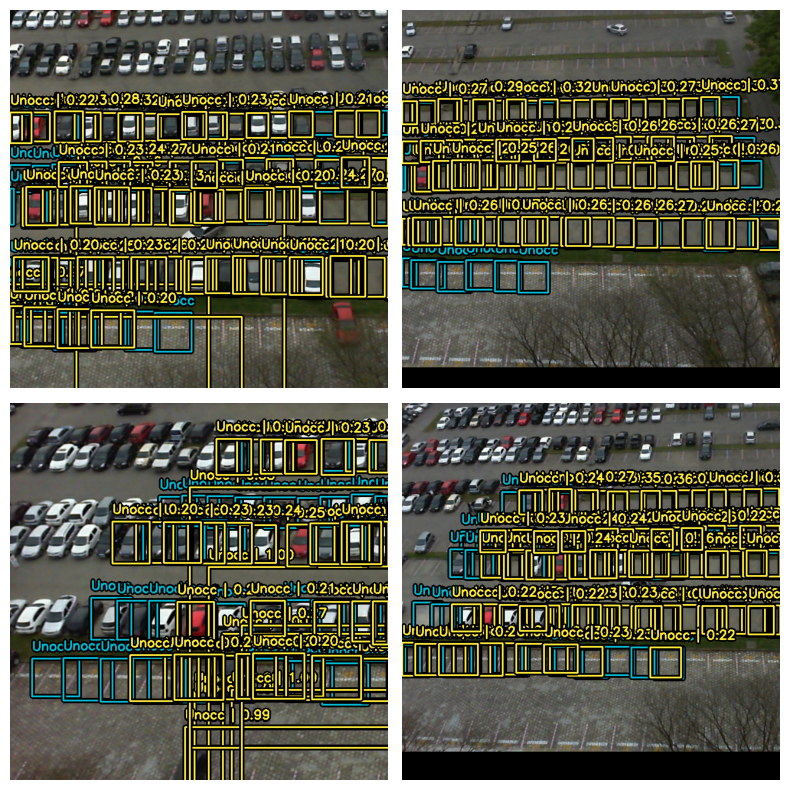

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="CENTER_XYWH")

In [ ]:
# Save if a new model was trained:
yolo.save("/content/drive/My Drive/Colab Notebooks/yolo.keras")

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="CENTER_XYWH",
)

In [ ]:
test_ds = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1 * 4)
test_ds = test_ds.ragged_batch(1, drop_remainder=True)
test_ds = test_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Get test set metrics:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    #print(images.shape)
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    #print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

result = yolo.evaluate(test_ds, batch_size=128)
yolo_test_metrics = dict(zip(yolo.metrics_names, result))
visualize_detections(yolo, dataset=test_ds, bounding_box_format="CENTER_XYWH")

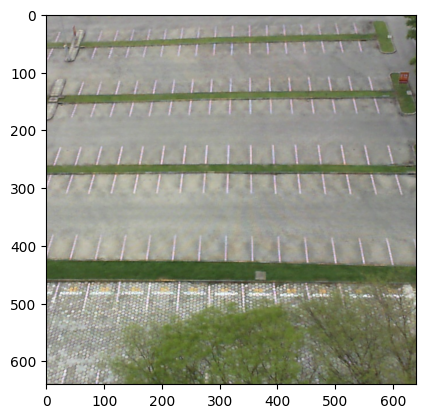

1/1 [==============================] - 3s 3s/step


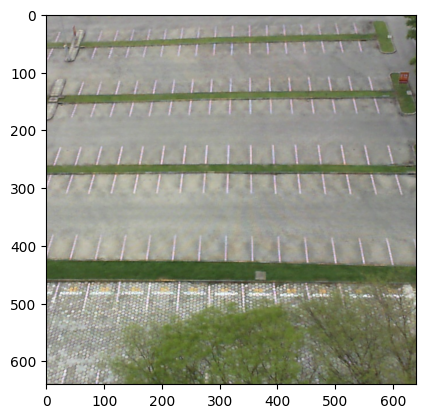

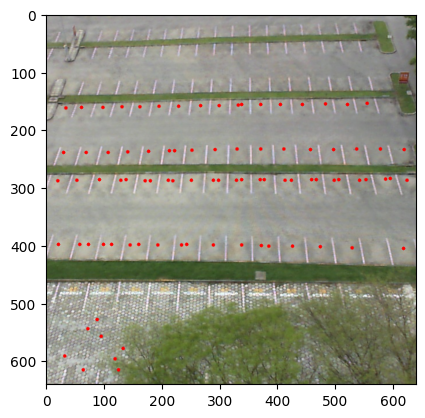

19.924858845171276
droped 8
6.082762530298219
droped 30
9.055385138137417
droped 65
9.0
droped 70
9.0
droped 85
8.06225774829855
droped 87
9.0
droped 53
9.055385138137417
droped 71
11.045361017187261
droped 67
15.0
droped 77
8.06225774829855
droped 69
15.033296378372908
droped 88
7.0
droped 64
11.0
droped 74
8.06225774829855
droped 79
14.0
droped 72
8.0
droped 84
9.055385138137417
droped 82
13.038404810405298
droped 86


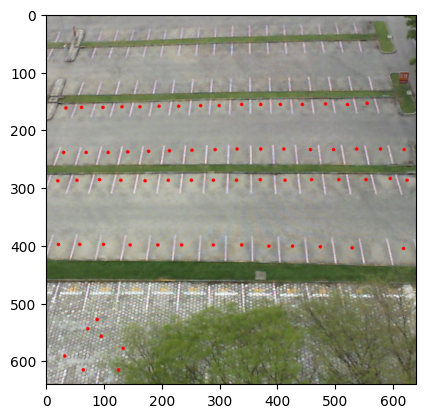

In [ ]:
def get_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    plt.imshow(images[0].numpy().astype(np.uint8))
    plt.show()
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    bbox_i = y_pred["boxes"][0].numpy()
    bbox_i_conf = y_pred["confidence"][0].numpy()

    # Show orginal image:

    imgTemp = images[0].numpy()
    imgTemp = imgTemp[0:720,0:1280]
    plt.imshow(imgTemp.astype(np.uint8))
    plt.show()
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/original_img.jpg', cv2.cvtColor(imgTemp,cv2.COLOR_BGR2RGB))

    # Get centrioids from bounding boxes:
    centroid_df = pd.DataFrame()
    centroid_x = []
    centroid_y = []

    for j in range(0, bbox_i.shape[0]):
      # https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html
      # if above a certain confidence add to list of centroids
      if bbox_i_conf[j] > 0.25:
        imgTemp = cv2.circle(imgTemp, (int(bbox_i[j][0]), int(bbox_i[j][1])), radius=3, color=(255, 0, 0), thickness=-1)
        centroid_x.append(int(bbox_i[j][0]))
        centroid_y.append(int(bbox_i[j][1]))

    plt.imshow(imgTemp.astype(np.uint8))
    plt.show()
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/centroid_img.jpg', cv2.cvtColor(imgTemp,cv2.COLOR_BGR2RGB))

    # Remove duplicates:
    centroid_df["x-pixel"] = centroid_x
    centroid_df["y-pixel"] = centroid_y

    centroid_df_temp = centroid_df.copy(deep=True)
    centroid_df_temp["Drop"] = 'N'

    for i in range(0, len(centroid_df)):
      current_x = centroid_df.iloc[i, 0]
      current_y = centroid_df.iloc[i, 1]
      for j in range(0, len(centroid_df)):
        check_x = centroid_df.iloc[j, 0]
        check_y = centroid_df.iloc[j, 1]
        dist_i_j = np.sqrt((check_x - current_x)**2 + (check_y - current_y)**2)
        if dist_i_j > 0.1 and dist_i_j < 20 and centroid_df_temp.iloc[i, 2] == 'N':
          print(dist_i_j)
          print("droped " + str(j))
          centroid_df_temp.iloc[j, 2] = 'Y'


    imgTemp2 = images[0].numpy()
    centroid_df_temp.drop(centroid_df_temp[centroid_df_temp["Drop"] == 'Y'].index, inplace = True)
    for i in range(0, len(centroid_df_temp)):
      # https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html
      # if above a certain confidence add to list of centroids
      imgTemp2 = cv2.circle(imgTemp2, (int(centroid_df_temp.iloc[i, 0]), int(centroid_df_temp.iloc[i, 1])), radius=3, color=(255, 0, 0), thickness=-1)
    plt.imshow(imgTemp2.astype(np.uint8))
    plt.show()
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/centroid_img_reduced.jpg', cv2.cvtColor(imgTemp2,cv2.COLOR_BGR2RGB))

    centroid_df_temp.drop(["Drop"], axis=1)
    centroid_df_temp.to_csv("/content/drive/My Drive/Colab Notebooks/image_centroids.csv")

get_detections(yolo, dataset=test_ds, bounding_box_format="CENTER_XYWH")

